In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn


import umap

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#os.chdir('/home/fujoshua/cell_classification/model_outputs')
os.chdir('/nfs/turbo/umms-welchjd/mccell')

In [3]:
outputs = pd.read_csv('2024-04-08_results.csv')

In [4]:
outputs

,epoch,accuracy_train_leaf_hist,loss_train_hist,loss_train_leaf_hist,loss_train_internal_hist,accuracy_val_leaf_hist,loss_val_hist,loss_val_leaf_hist,loss_val_internal_hist,f1_score_train_leaf,f1_score_val_leaf,f1_score_train_internal,f1_score_val_internal
0,1,62.464016,4.260474,3.970087,0.290387,32.710628,NaN,NaN,0.147584,0.644849,0.572534,0.814154,0.705249


## Accuracy


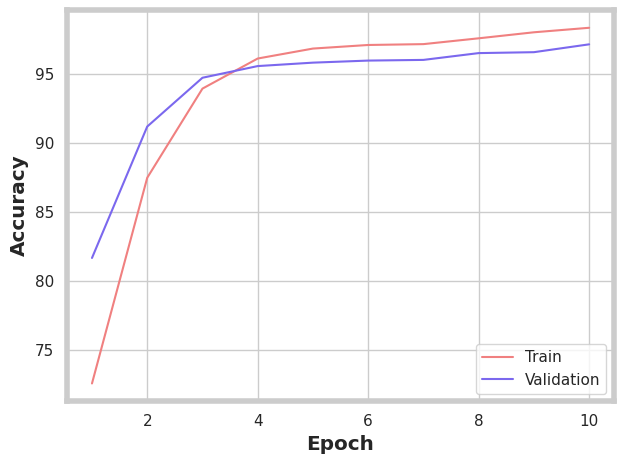

In [12]:

sns.lineplot(data=outputs,x='epoch',y='accuracy_train_leaf_hist', 
                color='lightcoral',label='Train')
sns.lineplot(data=outputs,x='epoch',y='accuracy_val_leaf_hist', 
                color='mediumslateblue',label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

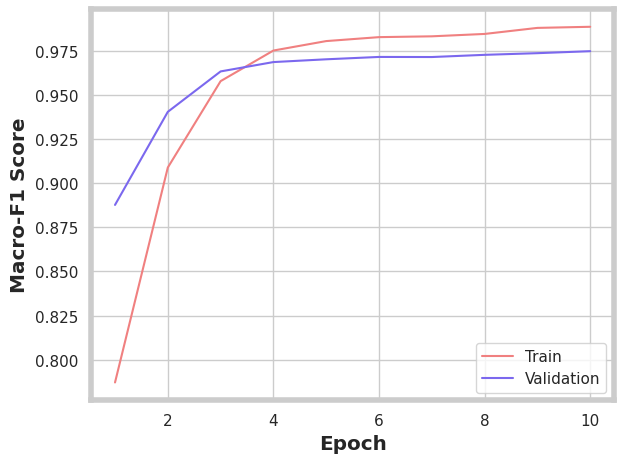

In [14]:
sns.lineplot(data=outputs,x='epoch',y='f1_score_train_leaf', 
                color='lightcoral',label='Train')
sns.lineplot(data=outputs,x='epoch',y='f1_score_val_leaf', 
                color='mediumslateblue',label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Macro-F1 Score')
plt.legend(loc='lower right')
plt.show()

## UMAP the predicted outputs

In [2]:
os.chdir('/home/fujoshua/cell_classification/model_outputs')
targets = torch.load('targets_good_1Dec.pt')#,map_location=torch.device('cpu'))
outputs = torch.load('output_good_1Dec.pt')#,map_location=torch.device('cpu'))

In [3]:
outputs.shape

torch.Size([110413, 85])

In [4]:
fit = umap.UMAP()

Started at 12:00 with 241414 cells and 52 outputs. Finished about 12:57 on CPU
Started at 12:17 with 110413 cell and 85 outputs. Finished about 12:29 on GPU/CPU?

In [6]:
u = fit.fit_transform(outputs.cpu().detach().numpy())


In [7]:
u.shape


(110413, 2)

In [20]:
#u = fit.transform(clf.linear3.weight.detach().numpy())


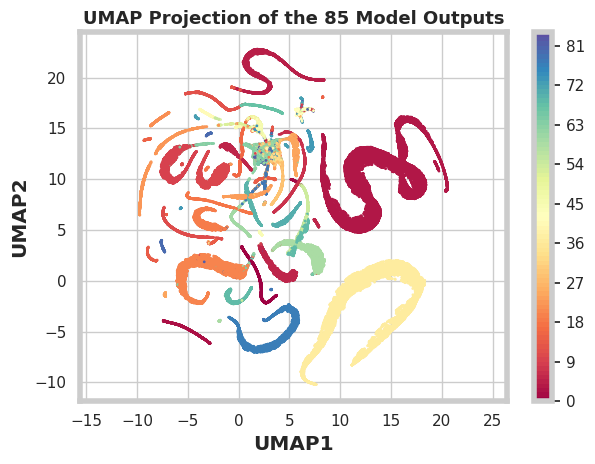

In [9]:
# cmap options tab20c, spectral

plt.scatter(u[:,0],u[:,1],c=targets.cpu().detach(),cmap='Spectral',s=1)
plt.gca().set_aspect('equal', 'datalim')

plt.colorbar(boundaries=np.arange(85))#-0.5)#.set_ticks(np.arange(52))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of the 85 Model Outputs',fontsize=13)


plt.show()
